<a href="https://colab.research.google.com/github/aravindchakravarti/Deep_Learning_EVA_4/blob/master/S5_MNIST_Optimum_Parameter/EVA4_Session_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
# Import core module
import torch.nn as nn
# We need support for functional programming
import torch.nn.functional as F
import torch.optim as optim
# For MNIST dataset
from torchvision import datasets, transforms
# For Global Average Pooling
from torch.nn import AvgPool2d
# Plotting purpose
%matplotlib inline
import matplotlib.pyplot as plt

# Data Transformations
We first start with defining our data transformations. Image augmentation techniques are great and we need to keep it ready by the time we hit overfitting!

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train and Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The Model

I like the model definition like below, not with nn.Sequential() way. So, I am going to keep it same 

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)      #I=28, O=28, RF=3
        self.batch1 = nn.BatchNorm2d(num_features=8)    
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)      #I=28, O=28, RF=5
        self.batch2 = nn.BatchNorm2d(num_features=8)    
        self.conv3 = nn.Conv2d(8, 12, 3, padding=1)     #I=28, O=28, RF=7
        self.batch3 = nn.BatchNorm2d(num_features=12)   
        self.pool1 = nn.MaxPool2d(2, 2)                 #I=28, O=14, RF=14
        self.conv4 = nn.Conv2d(12, 10, 1)

        self.conv5 = nn.Conv2d(10, 16, 3, padding=1)    #I=14, O=14, RF=17
        self.batch4 = nn.BatchNorm2d(num_features=16)
        self.conv6 = nn.Conv2d(16, 16, 3, padding=1)    #I=14, O=14, RF=20
        self.batch5 = nn.BatchNorm2d(num_features=16)
        self.conv7 = nn.Conv2d(16, 16, 3, padding=1)    #I=14, O=14, RF=23
        self.batch6 = nn.BatchNorm2d(num_features=16)
        self.pool2 = nn.MaxPool2d(2, 2)                 #I=14, O=07, RF=26
        self.conv8 = nn.Conv2d(16, 10, 1)

        self.conv9 = nn.Conv2d(10, 32, 3, padding=0)    #I=07, O=05, RF=29
        self.batch7 = nn.BatchNorm2d(num_features=32)
        self.conv10 = nn.Conv2d(32, 10, 3, padding=0)   #I=05, O=03, RF=32
        self.batch8 = nn.BatchNorm2d(num_features=10)
        self.avg_pool = nn.AvgPool2d(kernel_size=3)

    def forward(self, x):
        x = self.batch1(F.dropout(F.relu(self.conv1(x)), 0.1))        #See above for Input\
        x = self.batch2(F.dropout(F.relu(self.conv2(x)), 0.1))                        #Output and Receptive Field
        x = self.batch3(F.dropout(F.relu(self.conv3(x)), 0.1))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))

        x = self.batch4(F.dropout(F.relu(self.conv5(x)), 0.1))
        x = self.batch5(F.dropout(F.relu(self.conv6(x)), 0.1))
        x = self.batch6(F.dropout(F.relu(self.conv7(x)), 0.1))
        x = self.pool2(x)
        x = F.relu(self.conv8(x))

        x = self.batch7(F.dropout(F.relu(self.conv9(x)), 0.1))
        x = self.batch8(F.relu(self.conv10(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 10)                           # Don't want 10x1x1..
        return F.log_softmax(x)

# Model Parameters and other details

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             584
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
         MaxPool2d-7           [-1, 12, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             130
            Conv2d-9           [-1, 16, 14, 14]           1,456
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,320
      BatchNorm2d-12           [-1, 16, 14, 14]              32
           Conv2d-13           [-1, 16, 14, 14]           2,320
      BatchNorm2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train the model

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.09181106090545654 Batch_id=468 Accuracy=92.14: 100%|██████████| 469/469 [00:11<00:00, 39.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1249, Accuracy: 9721/10000 (97.21%)

EPOCH: 1


Loss=0.0446719266474247 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0621, Accuracy: 9841/10000 (98.41%)

EPOCH: 2


Loss=0.059871744364500046 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:12<00:00, 38.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.06630530953407288 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:11<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.0201744232326746 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 39.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.02390124462544918 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:12<00:00, 38.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.04712200537323952 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9882/10000 (98.82%)

EPOCH: 7


Loss=0.03535665199160576 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:11<00:00, 39.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9893/10000 (98.93%)

EPOCH: 8


Loss=0.0066684880293905735 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 39.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.039772067219018936 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:11<00:00, 39.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


Loss=0.012701700441539288 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 43.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


Loss=0.032508064061403275 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 38.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.04752493277192116 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:11<00:00, 43.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9913/10000 (99.13%)

EPOCH: 13


Loss=0.006271605845540762 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 44.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9902/10000 (99.02%)

EPOCH: 14


Loss=0.05241447314620018 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:11<00:00, 39.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.08219270408153534 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 38.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9917/10000 (99.17%)

EPOCH: 16


Loss=0.018047526478767395 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 38.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9918/10000 (99.18%)

EPOCH: 17


Loss=0.01683890074491501 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 46.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9913/10000 (99.13%)

EPOCH: 18


Loss=0.012126552872359753 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 46.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9909/10000 (99.09%)

EPOCH: 19


Loss=0.01921655982732773 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.57it/s]



Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)



# Most important part - Plots


Text(0.5, 1.0, 'Test Accuracy')

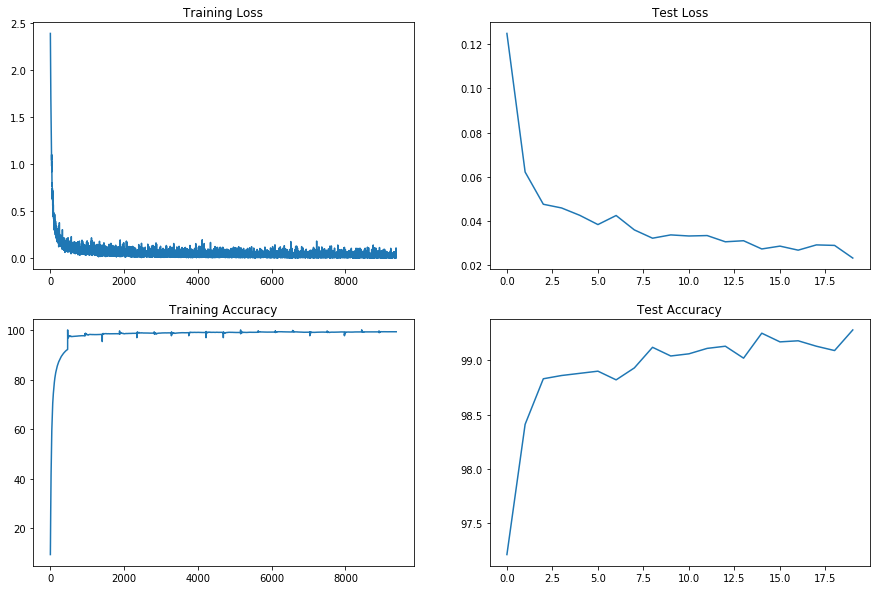

In [22]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")